In [13]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import MobileNetV2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

preprocessing to image data

In [11]:


# Image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for validation
)

In [12]:

train_data = train_datagen.flow_from_directory(
   "D://data science//datasets//pet//images",
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)


Found 5913 images belonging to 2 classes.


In [13]:
val_data = train_datagen.flow_from_directory(
   "D://data science//datasets//pet//images",
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 1477 images belonging to 2 classes.


Use MobileNetV2 for feature extraction


In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
print(base_model.output_shape)

(None, 7, 7, 1280)


In [15]:
def extract_features(generator, base_model):
    features = []
    labels = []
    for x_batch, y_batch in generator:
        batch_features = base_model.predict(x_batch)
        features.append(batch_features)
        labels.append(y_batch) 
        if len(features) >= len(generator):
            break
    print (f"{len(features)}      {len(generator)}")
    return np.vstack(features), np.vstack(labels)   # convert (features , labels) from list to narray

In [9]:
X_train, y_train = extract_features(train_data, base_model) # Extract features from the training data

X_val, y_val = extract_features(val_data, base_model) # Extract features from the validation data

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 997ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 986ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 953ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━

In [16]:
print(X_train.shape)
# print(x_val.shape)
# Flatten the features
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
# type(X_train)

(5913, 7, 7, 1280)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial')
log_reg.fit(X_train, y_train.argmax(axis=1))

# Predict and evaluate
y_pred_lr = log_reg.predict(X_val)
print("Logistic Regression Accuracy:", accuracy_score(y_val.argmax(axis=1), y_pred_lr))
print(classification_report(y_val.argmax(axis=1), y_pred_lr))

Logistic Regression Accuracy: 0.963439404197698
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       476
           1       0.98      0.97      0.97      1001

    accuracy                           0.96      1477
   macro avg       0.96      0.96      0.96      1477
weighted avg       0.96      0.96      0.96      1477



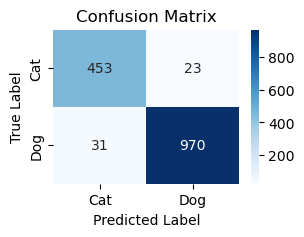

In [21]:
cm = confusion_matrix(y_val.argmax(axis=1), y_pred_lr)

plt.figure(figsize=(3,2))
sns.heatmap(cm,fmt = 'd',annot =True,cmap = 'Blues', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

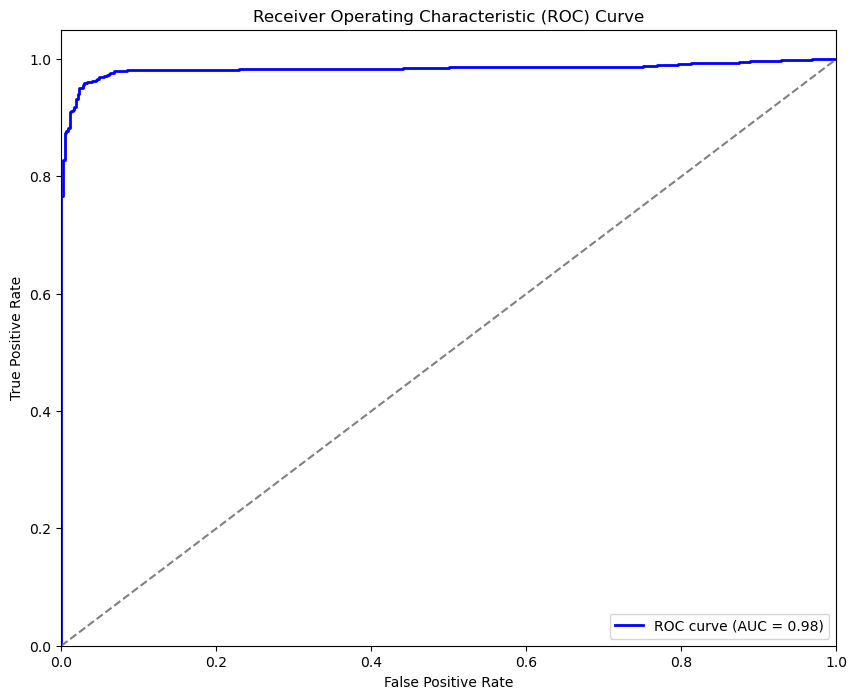

AUC Score: 0.983514384774889


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

 
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial')
log_reg.fit(X_train, y_train.argmax(axis=1)) 
 
y_prob = log_reg.predict_proba(X_val)

 
fpr, tpr, thresholds = roc_curve(y_val.argmax(axis=1), y_prob[:, 1])

 
roc_auc = auc(fpr, tpr)

 
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

 
print("AUC Score:", roc_auc)

In [19]:

accuracy_score(y_val.argmax(axis=1), y_pred_lr)

0.963439404197698

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


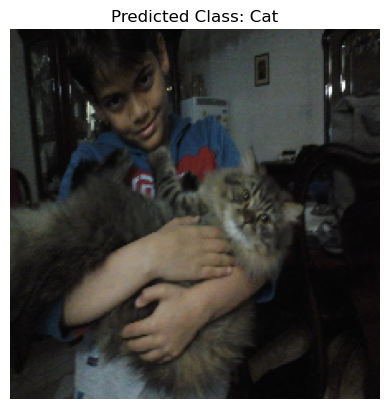

In [30]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


img_path = r"D:\data science\datasets\pet\WhatsApp Image 2024-12-15 at 00.22.42_07e4fed1.jpg" 
img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0) 
img_array /= 255.0  

features = base_model.predict(img_array)  
features_flat = features.flatten().reshape(1, -1)  


prediction = log_reg.predict(features_flat)  
class_index = prediction[0]  

class_labels = {0: 'Cat', 1: 'Dog'}  
predicted_label = class_labels[class_index]

# 5. Display the result
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted Class: {predicted_label}")
plt.show()